# Basic examples

In this notebook we will show how to compute correlation functions with various binning schemes of survey and periodic data, how to dump them to disk, etc.
You need to have installed **pycorr** with:
```
python -m pip install git+https://github.com/adematti/pycorr#egg=pycorr[corrfunc]
```

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator,\
                   project_to_multipoles, project_to_wp, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000.,0.,0.), n_individual_weights=1, seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
        weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
        toret.append((positions, weights))
    return toret

In [3]:
# First, generate fake data with cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=84)

## High-level interface
Here we use the high-level interface, that will take care of computing pair counts.

### Survey data

For survey data, we will use the Landy-Szalay estimator.

In [4]:
# Compute the s-mu cross-correlation function, with 50 bins between 1e-9 (to remove self-pairs) and 100
# and 100 mu-bins between 0 and 1, using Corrfunc and 4 OpenMP threads
edges = (np.linspace(1e-9, 100, 51), np.linspace(0, 1., 101))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     engine='corrfunc', nthreads=4)

[000000.03]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000000.04]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000000.73]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000001.45]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D2R1.
[000002.17]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


In [5]:
# s, mu and weighted counts can be obtained through:
print(result.sep.shape, result.seps[1].shape, result.corr.shape)

(50, 100) (50, 100) (50, 100)


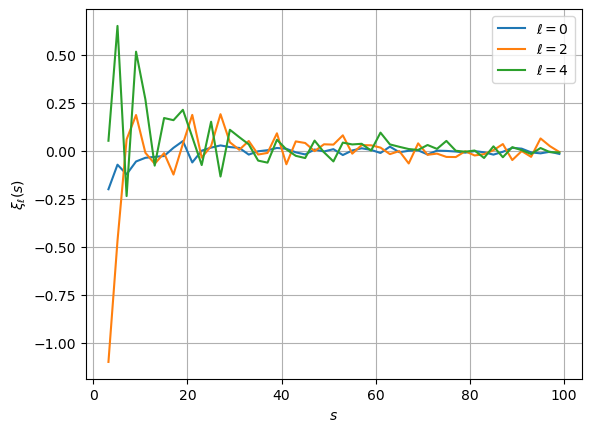

In [6]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = project_to_multipoles(result, ells=ells)
ax = plt.gca()
for ill,ell in enumerate(ells):
    ax.plot(s, xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$\xi_{\ell}(s)$')
plt.show()
# Zero correlation, as expected

In [7]:
# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    # And reload the result
    result = TwoPointEstimator.load(fn)
    print(result.autocorr)

[000003.68]  01-22 15:34  LandySzalayTwoPointEstimator INFO     Saving /tmp/tmpgyix4ao4/tmp.npy.
[000003.69]  01-22 15:34  TwoPointEstimator            INFO     Loading /tmp/tmpgyix4ao4/tmp.npy.
False


In [8]:
# You can reuse a precomputed R1R2 result.R1R2
result2 = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                      data_positions2=data_positions2, data_weights2=data_weights2,
                                      randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                      randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                      engine='corrfunc', R1R2=result.R1R2, nthreads=4)

mask = np.isfinite(result.corr)
assert np.allclose(result2.corr[mask], result.corr[mask])

[000003.70]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000003.71]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000004.21]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000004.92]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D2R1.
[000005.63]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using precomputed two-point counts R1R2.


[000005.65]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000005.66]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000005.71]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000005.78]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D2R1.
[000005.85]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


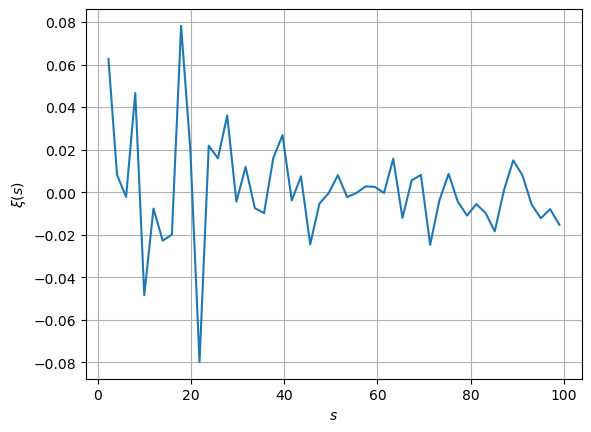

In [9]:
# Other binning are "s", "rppi"
edges = np.linspace(1, 100, 51)
result = TwoPointCorrelationFunction('s', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     engine='corrfunc', nthreads=4)
ax = plt.gca()
ax.plot(result.sep, result.corr)
ax.set_xlabel('$s$')
ax.set_ylabel(r'$\xi(s)$')
ax.grid(True)
plt.show()

[000006.19]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000006.19]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000006.31]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000006.59]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


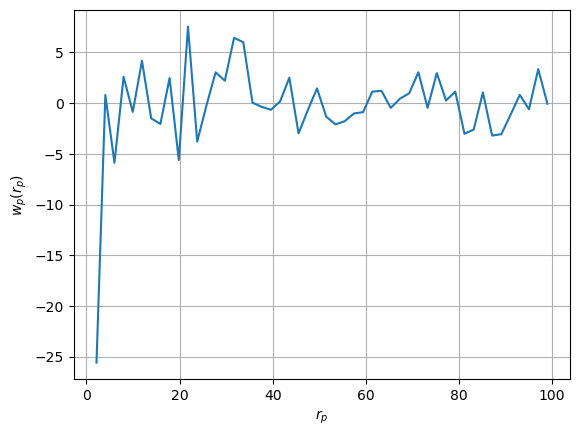

In [10]:
# Here we compute rp-pi auto-correlation
edges = (np.linspace(1, 100, 51), np.linspace(0, 50, 51))
result = TwoPointCorrelationFunction('rppi', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     engine='corrfunc', nthreads=4)
ax = plt.gca()
sep, wp = project_to_wp(result, pimax=None)
ax.plot(sep, wp)
ax.set_xlabel('$r_{p}$')
ax.set_ylabel(r'$w_{p}(r_{p})$')
ax.grid(True)
plt.show()

[000007.00]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000007.00]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000007.08]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000007.63]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


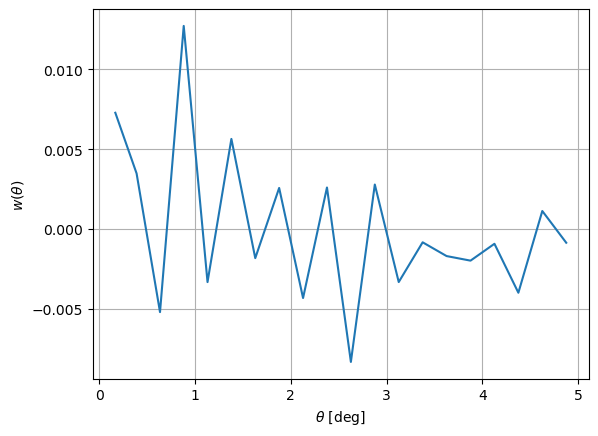

In [11]:
# Here we compute angular auto-correlation, without weights
# we provide cartesian positions instead of RA/Dec, so say position_type='xyz'
edges = np.linspace(1e-4, 5, 21)
result = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     engine='corrfunc', position_type='xyz', nthreads=4)
ax = plt.gca()
ax.plot(result.sep, result.corr)
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.grid(True)
plt.show()

[000009.20]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000009.20]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000009.30]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000009.89]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000011.30]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000011.30]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000011.38]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000012.71]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.DavisPeeblesTwoPointEstimator'>.
[000012.71]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-po

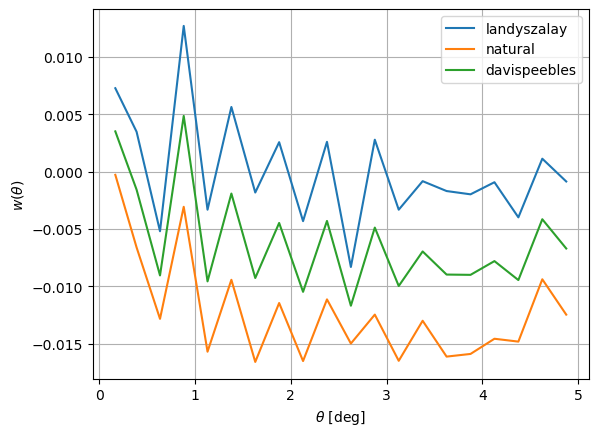

In [12]:
# Here we test different estimators
edges = np.linspace(1e-4, 5, 21)
kwargs = dict(engine='corrfunc', position_type='xyz', nthreads=4)
result_szalay = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                            randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                            estimator='landyszalay', **kwargs)
result_natural = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                             randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                             estimator='natural', **kwargs)
result_davispeebles = TwoPointCorrelationFunction('theta', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                             randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                             estimator='davispeebles', **kwargs)
ax = plt.gca()
ax.plot(result.sep, result_szalay.corr, label='landyszalay')
ax.plot(result.sep, result_natural.corr, label='natural')
ax.plot(result.sep, result_davispeebles.corr, label='davispeebles')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.grid(True)
ax.legend()
plt.show()

[000013.57]  01-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000013.58]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000014.12]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1S2.
[000014.94]  01-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D2S1.
[000015.75]  01-22 15:35  TwoPointCorrelationFunction  INFO     Computing two-point counts S1S2.
[000016.83]  01-22 15:35  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.


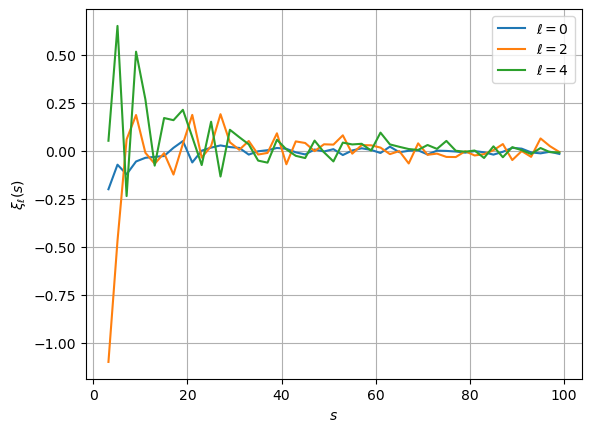

In [13]:
# In case of reconstruction, using shifted catalogs random catalogs (here we just use the same)
# This will compute (D1D2 - D1S2 - D2S1 - S1S2)/R1R2
shifted_positions1, shifted_weights1 = randoms_positions1, randoms_weights1
shifted_positions2, shifted_weights2 = randoms_positions2, randoms_weights2
edges = (np.linspace(1e-9, 100, 51), np.linspace(0, 1., 101))
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1, data_weights1=data_weights1,
                                     data_positions2=data_positions2, data_weights2=data_weights2,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                                     shifted_positions1=shifted_positions1, shifted_weights1=shifted_weights1,
                                     shifted_positions2=shifted_positions2, shifted_weights2=shifted_weights2,
                                     engine='corrfunc', nthreads=4)

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = project_to_multipoles(result, ells=ells)
ax = plt.gca()
for ill,ell in enumerate(ells):
    ax.plot(s, xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$s$')
ax.set_ylabel(r'$\xi_{\ell}(s)$')
plt.show()
# Flat, as expected

### Periodic box data

For periodic box data, we will use the natural estimator. Syntax with the high-level interface is the same.

[000018.04]  01-22 15:35  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000018.04]  01-22 15:35  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000018.09]  01-22 15:35  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000018.12]  01-22 15:35  matplotlib.legend            WARNING  No handles with labels found to put in legend.


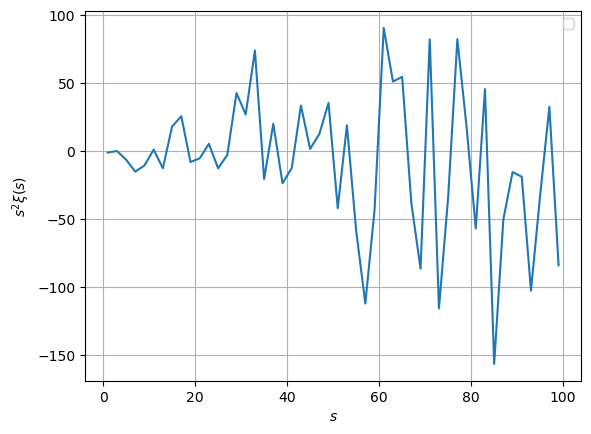

In [14]:
# Compute the s-correlation function, with 50 bins between 1e-9 (to remove self-pairs) and 100
edges = np.linspace(1e-9, 100, 51)
boxsize = 1000.
result = TwoPointCorrelationFunction('s', edges, data_positions1=data_positions1,
                                     engine='corrfunc', boxsize=boxsize, nthreads=4)

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ax = plt.gca()
ax.plot(result.sep, result.sep**2*result.corr)
ax.legend()
ax.set_xlabel('$s$')
ax.set_ylabel(r'$s^{2}\xi(s)$')
ax.grid(True)
plt.show()
# Flat, as expected

[000018.32]  01-22 15:35  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000018.33]  01-22 15:35  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000018.55]  01-22 15:35  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.


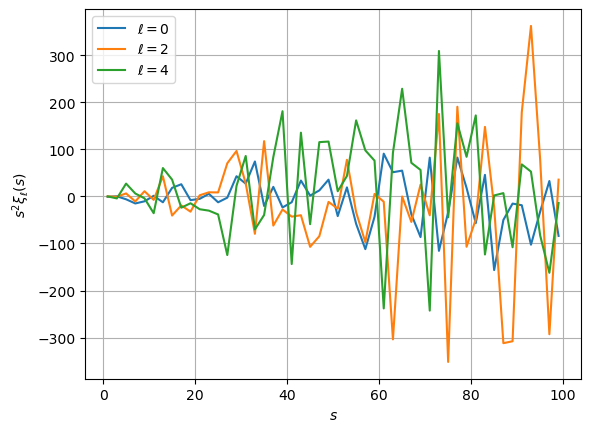

In [15]:
# Compute the s-mu correlation function, with 50 bins between 1e-9 (to remove self-pairs) and 100
# and 100 mu-bins between 0 and 1, using Corrfunc and 4 OpenMP threads
edges = (np.linspace(1e-9, 100, 51), np.linspace(0, 1., 101))
boxsize = 1000.
result = TwoPointCorrelationFunction('smu', edges, data_positions1=data_positions1,
                                     engine='corrfunc', boxsize=boxsize, los='z', nthreads=4)

# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
s, xiell = project_to_multipoles(result, ells=ells)
ax = plt.gca()
for ill,ell in enumerate(ells):
    ax.plot(s, s**2*xiell[ill], label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.set_xlabel('$s$')
ax.set_ylabel(r'$s^{2}\xi_{\ell}(s)$')
ax.grid(True)
plt.show()
# Flat, as expected

## Pair counters

Same results can be obtained directly from pair counters, e.g. for the last correlation function estimation.

In [16]:
from pycorr import TwoPointCounter, AnalyticTwoPointCounter, NaturalTwoPointEstimator
edges = (np.linspace(1e-9, 100, 51), np.linspace(0, 1., 101))
D1D2 = TwoPointCounter('smu', edges, positions1=data_positions1,
                       engine='corrfunc', boxsize=boxsize, los='z', nthreads=4)
R1R2 = AnalyticTwoPointCounter('smu', edges, boxsize=boxsize)

# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    D1D2.save(fn)
    # And reload the result
    D1D2 = TwoPointCounter.load(fn)

result2 = NaturalTwoPointEstimator(D1D2=D1D2, R1R2=R1R2)
mask = np.isfinite(result.corr)
assert np.allclose(result2.corr[mask], result.corr[mask])

[000019.08]  01-22 15:35  CorrfuncTwoPointCounter      INFO     Saving /tmp/tmpngqz02te/tmp.npy.
[000019.08]  01-22 15:35  TwoPointCounter              INFO     Loading /tmp/tmpngqz02te/tmp.npy.


## Rebinning
We provide methods to rebin correlation function estimation accurately, i.e. doing this for all pair counts.

In [17]:
print('Initially {:d} sep, {:d} mu.'.format(len(result.seps[0]), len(result.seps[1])))
result.rebin((2, 4))
print('After rebinning {:d} sep, {:d} mu.'.format(len(result.seps[0]), len(result.seps[1])))
# The same method exists for pair counts
result.D1D2.rebin((5, 1))

Initially 50 sep, 50 mu.
After rebinning 25 sep, 25 mu.


/local/home/adematti/Bureau/DESI/NERSC/cosmodesi/pycorr/pycorr/twopoint_counter.py:693: RuntimeWarning: invalid value encountered in true_divide
  self.seps = [utils.rebin(_nan_to_zero(sep)*wcounts, new_shape, statistic=np.sum)/self.wcounts for sep in self.seps]
